# Symbolic System

Create a symbolic three-state system:

In [1]:
import markoviandynamics as md
sym_system = md.SymbolicDiscreteSystem(3)

Get the symbolic equilibrium distribution:

In [2]:
sym_system.equilibrium()

Matrix([
[exp(-E_1/T)/(exp(-E_3/T) + exp(-E_2/T) + exp(-E_1/T))],
[exp(-E_2/T)/(exp(-E_3/T) + exp(-E_2/T) + exp(-E_1/T))],
[exp(-E_3/T)/(exp(-E_3/T) + exp(-E_2/T) + exp(-E_1/T))]])

Create a symbolic three-state system with potential energy barriers:

In [3]:
sym_system = md.SymbolicDiscreteSystemArrhenius(3)

It's the same object as the previous one, only with additional symbolic barriers:

In [4]:
sym_system.B_ij

Matrix([
[   0, B_12, B_13],
[B_21,    0, B_23],
[B_31, B_32,    0]])

We can assing values to the free parameters in the equilibrium distribution:

In [5]:
sym_system.equilibrium(energies=[0, 0.1, 1])

Matrix([
[          1/(1 + exp(-1.0/T) + exp(-0.1/T))],
[exp(-0.1/T)/(1 + exp(-1.0/T) + exp(-0.1/T))],
[exp(-1.0/T)/(1 + exp(-1.0/T) + exp(-0.1/T))]])

In [6]:
sym_system.equilibrium(energies=[0, 0.1, 1], temperature=1.5)

array([[0.40834259],
       [0.38200734],
       [0.20965007]])

and create multiple equilibrium points by assigning temperature sequence:

In [7]:
import numpy as np
temperature_range = np.linspace(0.01, 10, 300)

In [8]:
equilibrium_line = sym_system.equilibrium([0, 0.1, 1], temperature_range)

equilibrium_line.shape

(3, 300)

# Symbolic rate matrix

Create a symbolic rate matrix with Arrhenius process transitions:

In [9]:
sym_rate_matrix = md.SymbolicRateMatrixArrhenius(3)

sym_rate_matrix

Matrix([
[-exp((-B_21 + E_1)/T) - exp((-B_31 + E_1)/T),                         exp((-B_12 + E_2)/T),                         exp((-B_13 + E_3)/T)],
[                        exp((-B_21 + E_1)/T), -exp((-B_12 + E_2)/T) - exp((-B_32 + E_2)/T),                         exp((-B_23 + E_3)/T)],
[                        exp((-B_31 + E_1)/T),                         exp((-B_32 + E_2)/T), -exp((-B_13 + E_3)/T) - exp((-B_23 + E_3)/T)]])

Energies and barriers can be substituted at once:

In [10]:
energies = [0, 0.1, 1]
barriers = [[0, 0.11, 1.1], 
            [0.11, 0, 10], 
            [1.1, 10, 0]]

sym_rate_matrix.subs_symbols(energies, barriers)

Matrix([
[-exp(-1.1/T) - exp(-0.11/T),                exp(-0.01/T),                exp(-0.1/T)],
[               exp(-0.11/T), -exp(-9.9/T) - exp(-0.01/T),                exp(-9.0/T)],
[                exp(-1.1/T),                 exp(-9.9/T), -exp(-9.0/T) - exp(-0.1/T)]])

In [11]:
sym_rate_matrix.subs_symbols(energies, barriers, temperature=2.5)

array([[-1.60099038,  0.99600799,  0.96078944],
       [ 0.95695396, -1.0150711 ,  0.02732372],
       [ 0.64403642,  0.01906311, -0.98811316]])

A symbolic rate matrix can be also lambdified (transform to lambda function):

In [12]:
rate_matrix_lambdified = sym_rate_matrix.lambdify()

The parameters of this function are the free symbols in the rate matrix:

In [13]:
rate_matrix_lambdified.__code__.co_varnames

('T', 'E_1', 'E_2', 'E_3', 'B_12', 'B_13', 'B_21', 'B_23', 'B_31', 'B_32')

They are positioned in ascending order. First the temperature, then the energies and the barriers. Sequence of rate matrices can be created by calling this function with a sequence for each parameter.

# Dynamics

We start by computing an initial probability distribution by assigning the energies and temperature:

In [14]:
p_initial = sym_system.equilibrium(energies, 0.5)

p_initial

array([[0.51175343],
       [0.41898827],
       [0.0692583 ]])

## Trajectory - evolve by a fixed rate matrix

Compute the rate matrix by substituting free symbols:

In [15]:
rate_matrix = md.rate_matrix_arrhenius(energies, barriers, 1.2)

rate_matrix

array([[-1.31225889e+00,  9.91701293e-01,  9.20044415e-01],
       [ 9.12409235e-01, -9.91962551e-01,  5.53084370e-04],
       [ 3.99849654e-01,  2.61258557e-04, -9.20597499e-01]])

Create trajectory of probability distributions in time:

In [16]:
import numpy as np

# Create time sequence
t_range = np.linspace(0, 5, 100)

trajectory = md.evolve(p_initial, rate_matrix, t_range)

trajectory.shape

(3, 1, 100)

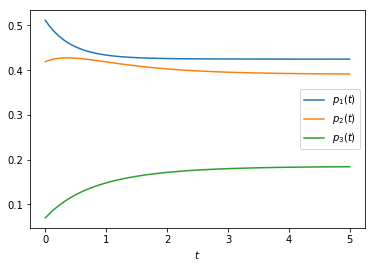

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in [0, 1, 2]:
    plt.plot(t_range, trajectory[i,0,:], label='$p_{}(t)$'.format(i + 1))
plt.xlabel('$t$')
plt.legend()

## Trajectory - evolve by a time-dependent rate matrix

Create a temperature sequence in time:

In [18]:
temperature_time = 1.4 + np.sin(4. * t_range)

Create a rate matrix as a function of the temperature sequence:

In [19]:
# Array of stacked rate matrices that corresponds to ``temperature_time``
rate_matrix_time = md.rate_matrix_arrhenius(energies, barriers, temperature_time)

rate_matrix_time.shape

(3, 3, 100)

In [20]:
crazy_trajectory = md.evolve(p_initial, rate_matrix_time, t_range)

crazy_trajectory.shape

(3, 1, 100)

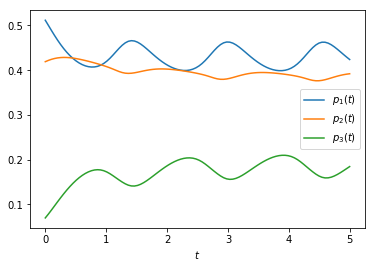

In [21]:
for i in [0, 1, 2]:
    plt.plot(t_range, crazy_trajectory[i,0,:], label='$p_{}(t)$'.format(i + 1))
plt.xlabel('$t$')
plt.legend()

# Diagonalize the rate matrix

Calculate the eigenvalues, left and right eigenvectors:

In [22]:
U, eigenvalues, V = md.eigensystem(rate_matrix)

U.shape, eigenvalues.shape, V.shape

((3, 3), (3,), (3, 3))

The eigenvalues are in descending order (the eigenvectors are ordered accordingly):

In [23]:
eigenvalues

array([-4.16333634e-17, -9.41880477e-01, -2.28293846e+00])

We can also compute the eigensystem for multiple rate matrices at once (or evolution of a rate matrix, i.e., `rate_matrix_time`):

In [24]:
U, eigenvalues, V = md.eigensystem(rate_matrix_time)

U.shape, eigenvalues.shape, V.shape

((3, 3, 100), (1, 3, 100), (3, 3, 100))

# Decompose to rate matrix eigenvectors

A probability distribution, in general, can be decomposed to the right eigenvectors of the rate matrix:

$$\left|p\right\rangle = a_1\left|v_1\right\rangle + a_2\left|v_2\right\rangle + a_3\left|v_3\right\rangle$$

where $a_i$ is the coefficient of the i'th right eigenvector $\left|v_i\right\rangle$. A rate matrix that satisfies detailed balance has its first eigenvector as the equilibrium distribution $\left|\pi\right\rangle$. Therefore, *markovian-dynamics* normalizes $a_1$ to $1$ and decompose a probability distribution to 

$$\left|p\right\rangle = \left|\pi\right\rangle + a_2\left|v_2\right\rangle + a_3\left|v_3\right\rangle$$

Decompose ``p_initial``:

In [25]:
md.decompose(p_initial, rate_matrix)

array([[ 1.        ],
       [-0.73607168],
       [-0.96960168]])

We can decompose also multiple points and/or by multiple rate matrices. For example, decompose multiple points:

In [26]:
first_decomposition = md.decompose(equilibrium_line, rate_matrix)

first_decomposition.shape

(3, 300)

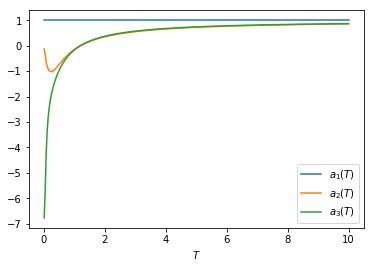

In [27]:
for i in [0, 1, 2]:
    plt.plot(temperature_range, first_decomposition[i,:], label='$a_{}(T)$'.format(i + 1))
plt.xlabel('$T$')
plt.legend()

or decompose a trajectory:

In [28]:
second_decomposition = md.decompose(trajectory, rate_matrix)

second_decomposition.shape

(3, 1, 100)

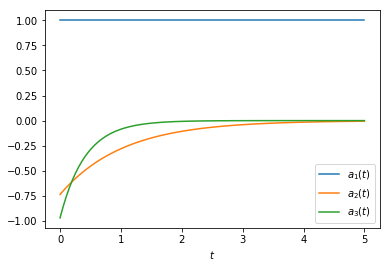

In [29]:
for i in [0, 1, 2]:
    plt.plot(t_range, second_decomposition[i,0,:], label='$a_{}(t)$'.format(i + 1))
plt.xlabel('$t$')
plt.legend()

Decompose single point using multiple rate matrices:

In [30]:
third_decomposition = md.decompose(p_initial, rate_matrix_time)

third_decomposition.shape

(3, 1, 100)

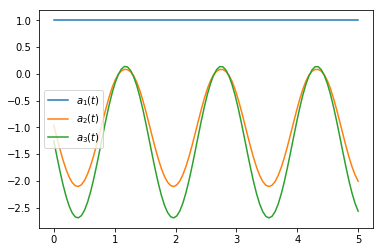

In [31]:
for i in [0, 1, 2]:
    plt.plot(t_range, third_decomposition[i,0,:], label='$a_{}(t)$'.format(i + 1))
plt.legend()

Decompose, for every time $t$, the corresponding point $\left|p(t)\right\rangle$ using the temporal rate matrix $R(t)$

In [32]:
fourth_decomposition = md.decompose(trajectory, rate_matrix_time)

fourth_decomposition.shape

(3, 1, 100)

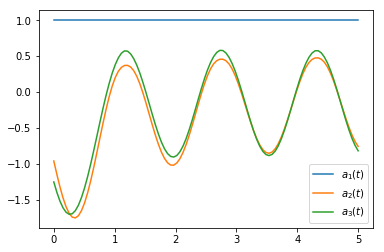

In [33]:
for i in [0, 1, 2]:
    plt.plot(t_range, fourth_decomposition[i,0,:], label='$a_{}(t)$'.format(i + 1))
plt.legend()

# Plotting the 2D probability simplex for three-state system

The probability space of a three-state system is a three dimensional space. However, the normalization constraint $\sum_{i}p_i=1$ together with $0 < p_i \le 1$, form a 2D triangular plane in which all of the possible probability points reside.

We'll start by importing the plotting module:

In [34]:
import markoviandynamics.plotting.plotting2d as plt2d

# Use latex rendering
plt2d.latex()

Plot the probability plane:

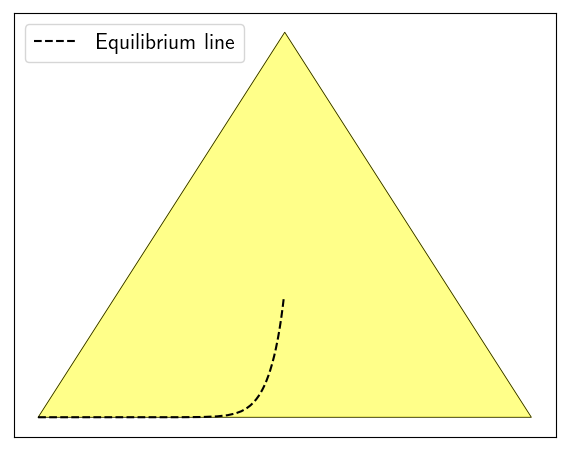

In [35]:
plt2d.figure(figsize=(7, 5.5))
plt2d.equilibrium_line(equilibrium_line)
plt2d.legend()

We can plot many objects on the probability plane, such as trajectories, points, and eigenvectors of the rate matrix:

In [36]:
# Final equilibrium point
p_final = sym_system.equilibrium(energies, 1.2)

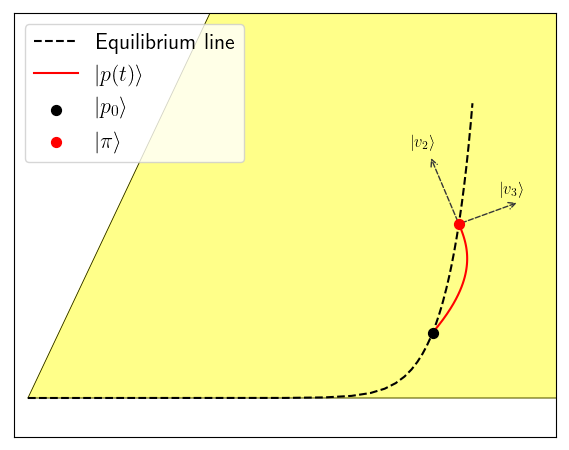

In [37]:
plt2d.figure(focus=True, figsize=(7, 5.5))
plt2d.equilibrium_line(equilibrium_line)

# Plot trajectory
plt2d.plot(trajectory, c='r', label=r'$\left|p(t)\right>$')

# Initial & final points
plt2d.point(p_initial, c='k', label=r'$\left|p_0\right>$')
plt2d.point(p_final, c='r', label=r'$\left|\pi\right>$')

# Eigenvectors
plt2d.eigenvectors(md.eigensystem(rate_matrix), kwargs_arrow={'zorder': 1})

plt2d.legend()

Plot multiple trajectories at once:

In [38]:
# Create temperature sequence
temperature_range = np.logspace(np.log10(0.01), np.log10(10), 50)

# Create the equilibrium line points
equilibrium_line = sym_system.equilibrium(energies, temperature_range)

# Create a trajectory for every point on ``equilibrium_line``
equilibrium_line_trajectory = md.evolve(equilibrium_line, rate_matrix, t_range)

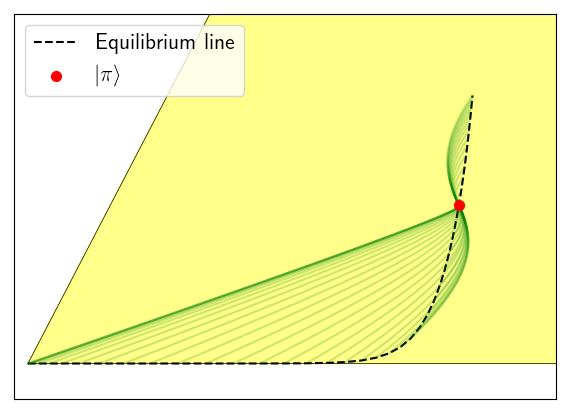

In [39]:
plt2d.figure(focus=True, figsize=(7, 5))
plt2d.equilibrium_line(equilibrium_line)
plt2d.plot(equilibrium_line_trajectory, c='g', alpha=0.2)
plt2d.point(p_final, c='r', label=r'$\left|\pi\right>$')
plt2d.legend()

In [40]:
# Create a trajectory for every point on ``equilibrium_line``
equilibrium_line_crazy_trajectory = md.evolve(equilibrium_line, rate_matrix_time, t_range)

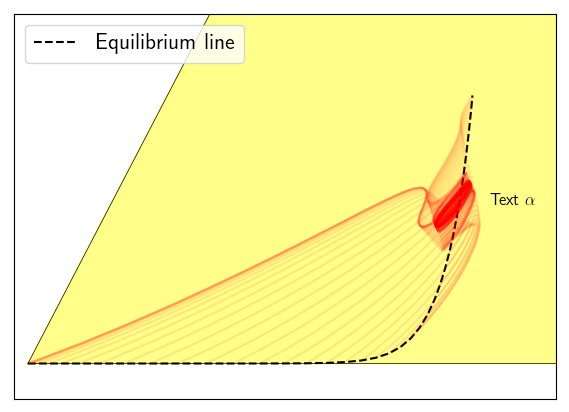

In [41]:
plt2d.figure(focus=True, figsize=(7, 5))
plt2d.equilibrium_line(equilibrium_line)
plt2d.plot(equilibrium_line_crazy_trajectory, c='r', alpha=0.1)
plt2d.text(p_final, r'Text $\alpha$', delta_x=0.05)
plt2d.legend()